In [47]:
import re
from glob import glob
import numpy as np
import pandas as pd
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from wordcloud import WordCloud

In [48]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# dados extraídos de: https://dadosabertos.camara.leg.br/swagger/api.html#staticfile
data_path = {
    'proposicoes': '/content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoes/*.xlsx',
    'autores': '/content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoesAutores/*.xlsx',
    'temas': '/content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoesTemas/*.xlsx',
}

In [50]:
# read xlsx files
data = {}

for k, p in data_path.items():
  print(f'reading {k} in {p}...')
  data[k] = pd.concat([pd.read_excel(f) for f in glob(p)])

reading proposicoes in /content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoes/*.xlsx...


/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


reading autores in /content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoesAutores/*.xlsx...
reading temas in /content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoesTemas/*.xlsx...


In [51]:
# filtering
# Apenas projetos de lei
data['proposicoes'] = data['proposicoes'].loc[data['proposicoes']['siglaTipo'] == 'PL']

In [52]:
# merging
dataset = data['proposicoes'].merge(data['autores'], suffixes=('_proposicao', '_autor'), left_on='id', right_on='idProposicao', how='left')
dataset = dataset.merge(data['temas'], left_on='uri', suffixes=('_proposicao', '_tema'), right_on='uriProposicao', how='left')
dataset = dataset[['id', 'ano_proposicao', 'ementa', 'ementaDetalhada', 'keywords', 'tema', 'nomeAutor', 'siglaPartidoAutor', 'siglaUFAutor', 'ordemAssinatura']]
dataset = dataset.rename(columns={'ano_proposicao': 'ano'})

In [53]:
dataset

id     ano                                             ementa  \
0        303153.0  2022.0  Dispõe sobre o exercício da profissão de Podól...   
1        587207.0  2022.0  Dispõe sobre a prestação dos serviços de contr...   
2        587207.0  2022.0  Dispõe sobre a prestação dos serviços de contr...   
3       2313792.0  2022.0  Determina às empresas de transporte de passage...   
4       2313792.0  2022.0  Determina às empresas de transporte de passage...   
...           ...     ...                                                ...   
186157   543876.0  1946.0  ASSEGURA O INGRESSO NA CLASSE INICIAL DA CARRE...   
186158   607205.0  1946.0  DISPÕE SOBRE A EXPEDIÇÃO DE DIPLOMAS DE BACHAR...   
186159   556557.0  1945.0  DÁ NOVA REDAÇÃO AOS ARTIGOS 817 E 830 DO CÓDIG...   
186160   347964.0  1935.0                                                NaN   
186161   517496.0  1934.0         MODIFICA DISPOSITIVOS DO CÓDIGO ELEITORAL.   

                                          ementaDetalhada  \
0       Regulamentando o exercício profissional da Pod...   
1                                                     NaN   
2                                                     NaN   
3                                                     NaN   
4                                                     NaN   
...                                                   ...   
186157                                                NaN   
186158                                                NaN   
186159                                                NaN   
186160                                                NaN   
186161                                                NaN   

                                                 keywords  \
0       Regulamentação, profissão, Podólogo, competênc...   
1       Regulamentação, atividade, empresa especializa...   
2       Regulamentação, atividade, empresa especializa...   
3       Obrigatoriedade, Empresa de transporte, transp...   
4       Obrigatoriedade, Empresa de transporte, transp...   
...                                                   ...   
186157                                                NaN   
186158                                                NaN   
186159                                                NaN   
186160                                                NaN   
186161                                                NaN   

                                               tema  \
0                                Trabalho e Emprego   
1                    Indústria, Comércio e Serviços   
2                                             Saúde   
3                       Direitos Humanos e Minorias   
4       Meio Ambiente e Desenvolvimento Sustentável   
...                                             ...   
186157                                          NaN   
186158                                          NaN   
186159                                          NaN   
186160                                          NaN   
186161                                          NaN   

                                               nomeAutor siglaPartidoAutor  \
0                                            José Mentor                PT   
1                                       Laercio Oliveira                PR   
2                                       Laercio Oliveira                PR   
3                                            Odair Cunha                PT   
4                                            Odair Cunha                PT   
...                                                  ...               ...   
186157                                JOSE FONTES ROMERO               NaN   
186158                                     MEDEIROS NETO               NaN   
186159                                   Poder Executivo               NaN   
186160                    Comissão do Código Eleitoral 2               NaN   
186161  COMISSÃO ESPECIAL DE REFORMA DO CÓDIGO ELEITORAL             

In [54]:
dataset.to_csv('output_file.gzip', compression='gzip')

# Filtros

In [55]:
# @title Filtros
ano_start = 1963 # @param {type:"slider", min:1934, max:2022, step:1}
ano_end = 1986 # @param {type:"slider", min:1934, max:2022, step:1}
partido = "" # @param ["", "PT", "PR", "PDT", "PSDB", "PSOL", "PCdoB", "PSB", "PSD", "PV", "SOLIDARI", "PODE", "AVANTE", "PP", "REPUBLIC", "PTB", "PSL", "MDB", "CIDADANIA", "PL", "DEM", "PATRIOTA", "PSC", "UNIÃO", "NOVO", "PROS", "REDE", "S.PART.", "PODEMOS", "PMDB", "PRB", "SD", "REPUB", "Podemos", "PPS", "PHS", "PEN", "PATRI", "S/Partido", "PTC", "PTN", "SOLIDARIED", "PMN", "SemPartido", "PRP", "PTdoB", "PMB", "S Partido", "SDD", "PSDC", "PRTB", "Rede", "PMBD", "PC do B", "PC DOB", "S/Part", "PT -", "PC DO  B", "pRB", "psdb", "pp", "pdt", "prb", "pmdb", "pt", "Nn", "nm", "NN", "AA", "PSBD", "dem", "PCDB", "PFL", "DOM", "PSBB", "PAN", "S/PARTIDO", "PRONA", "PMR", "PPB", "SPART", "PST", "PBDB", "PCDOB", "PPR", "PSTU", "PRN", "PDS", "PDC", "PTR", "PCB", "PRS", "PLP", "PTDOB", "PJ", "PDB", "PS", "PDMB", "PMDF", "MDB*", "ARENA", "PP**", "PNI", "Arena", "UDN", "MEB", "MTR", "PSP", "MRT", "PRT"]

In [57]:
dataset = dataset.loc[dataset['ano'] >= ano_start]
dataset = dataset.loc[dataset['ano'] <= ano_end]
if partido:
  dataset = dataset.loc[dataset['siglaPartidoAutor'] == partido]

# Processamento do texto

In [58]:
# transform data to get only text inputs
def join_text(line):
  ementa, ementaDetalhada, keywords = line['ementa'], line['ementaDetalhada'], line['keywords']
  text = ''
  if not pd.isna(ementa):
    text += ementa
  if not pd.isna(ementaDetalhada):
    text += ' ' + ementaDetalhada
  if not pd.isna(keywords):
    text += ' ' + keywords
  return text
dataset['documents'] = dataset[['ementa', 'ementaDetalhada', 'keywords']].agg(join_text, axis=1)

In [59]:
# drop all columns except id and documents
dataset = dataset.drop(columns=[c for c in dataset.columns if c not in ['id', 'documents']])
# drop nan
dataset = dataset.replace('', np.nan)
dataset = dataset.dropna(subset=['documents'])

In [60]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:
stemmer = PorterStemmer()
pt_stopwords = stopwords.words('portuguese')
pt_stopwords += ['lei', 'federal', 'nacional']

def tokenize_with_stemming(text):
  words = [word for word in word_tokenize(text) if word.lower() not in pt_stopwords]
  words = [word for word in words if re.match(r'^[a-z]+$', word)]
  return [stemmer.stem(word) for word in words]

vectorizer = TfidfVectorizer(strip_accents='ascii', tokenizer=tokenize_with_stemming)
X = vectorizer.fit_transform(dataset['documents'])

In [62]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
lsa_data = svd.fit_transform(X)
Sigma = svd.singular_values_
V_T = svd.components_.T

In [63]:
vocab = vectorizer.get_feature_names()
topics = []
topics_relevance = []
num_words = 10

for i, comp in enumerate(svd.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:num_words]
    topics_relevance.append(sorted_words)
    topics.append(', '.join([w for w, v in sorted_words]))

topics[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['trabalho, consolidacao, lei, previdencia, social, alteracao, empregado, servico, artigo, clt',
 'trabalho, consolidacao, lei, clt, empregado, maio, trabalhista, aprovada, jornada, contrato',
 'executivo, credito, poder, eleitor, municipio, especi, estado, autoriza, autorizacao, ministerio',
 'executivo, credito, especi, poder, previdencia, social, trabalho, abertura, autoriza, cr',
 'eleitor, codigo, partido, politico, organica, processo, tribun, eleicao, alteracao, artigo',
 'servico, tempo, eleitor, publico, aposentadoria, funcionario, fgt, contagem, servidor, especi',
 'ensino, publico, grau, superior, funcionario, aposentadoria, estabelecimento, servidor, curso, cargo',
 'fgt, ensino, conta, fundo, vinculada, garantia, tempo, grau, eleitor, servico',
 'municipio, estado, sao, paulo, publica, utilidad, seguranca, rio, sp, prefeito',
 'codigo, processo, civil, artigo, penal, alteracao, publico, transito, redacao, publica']

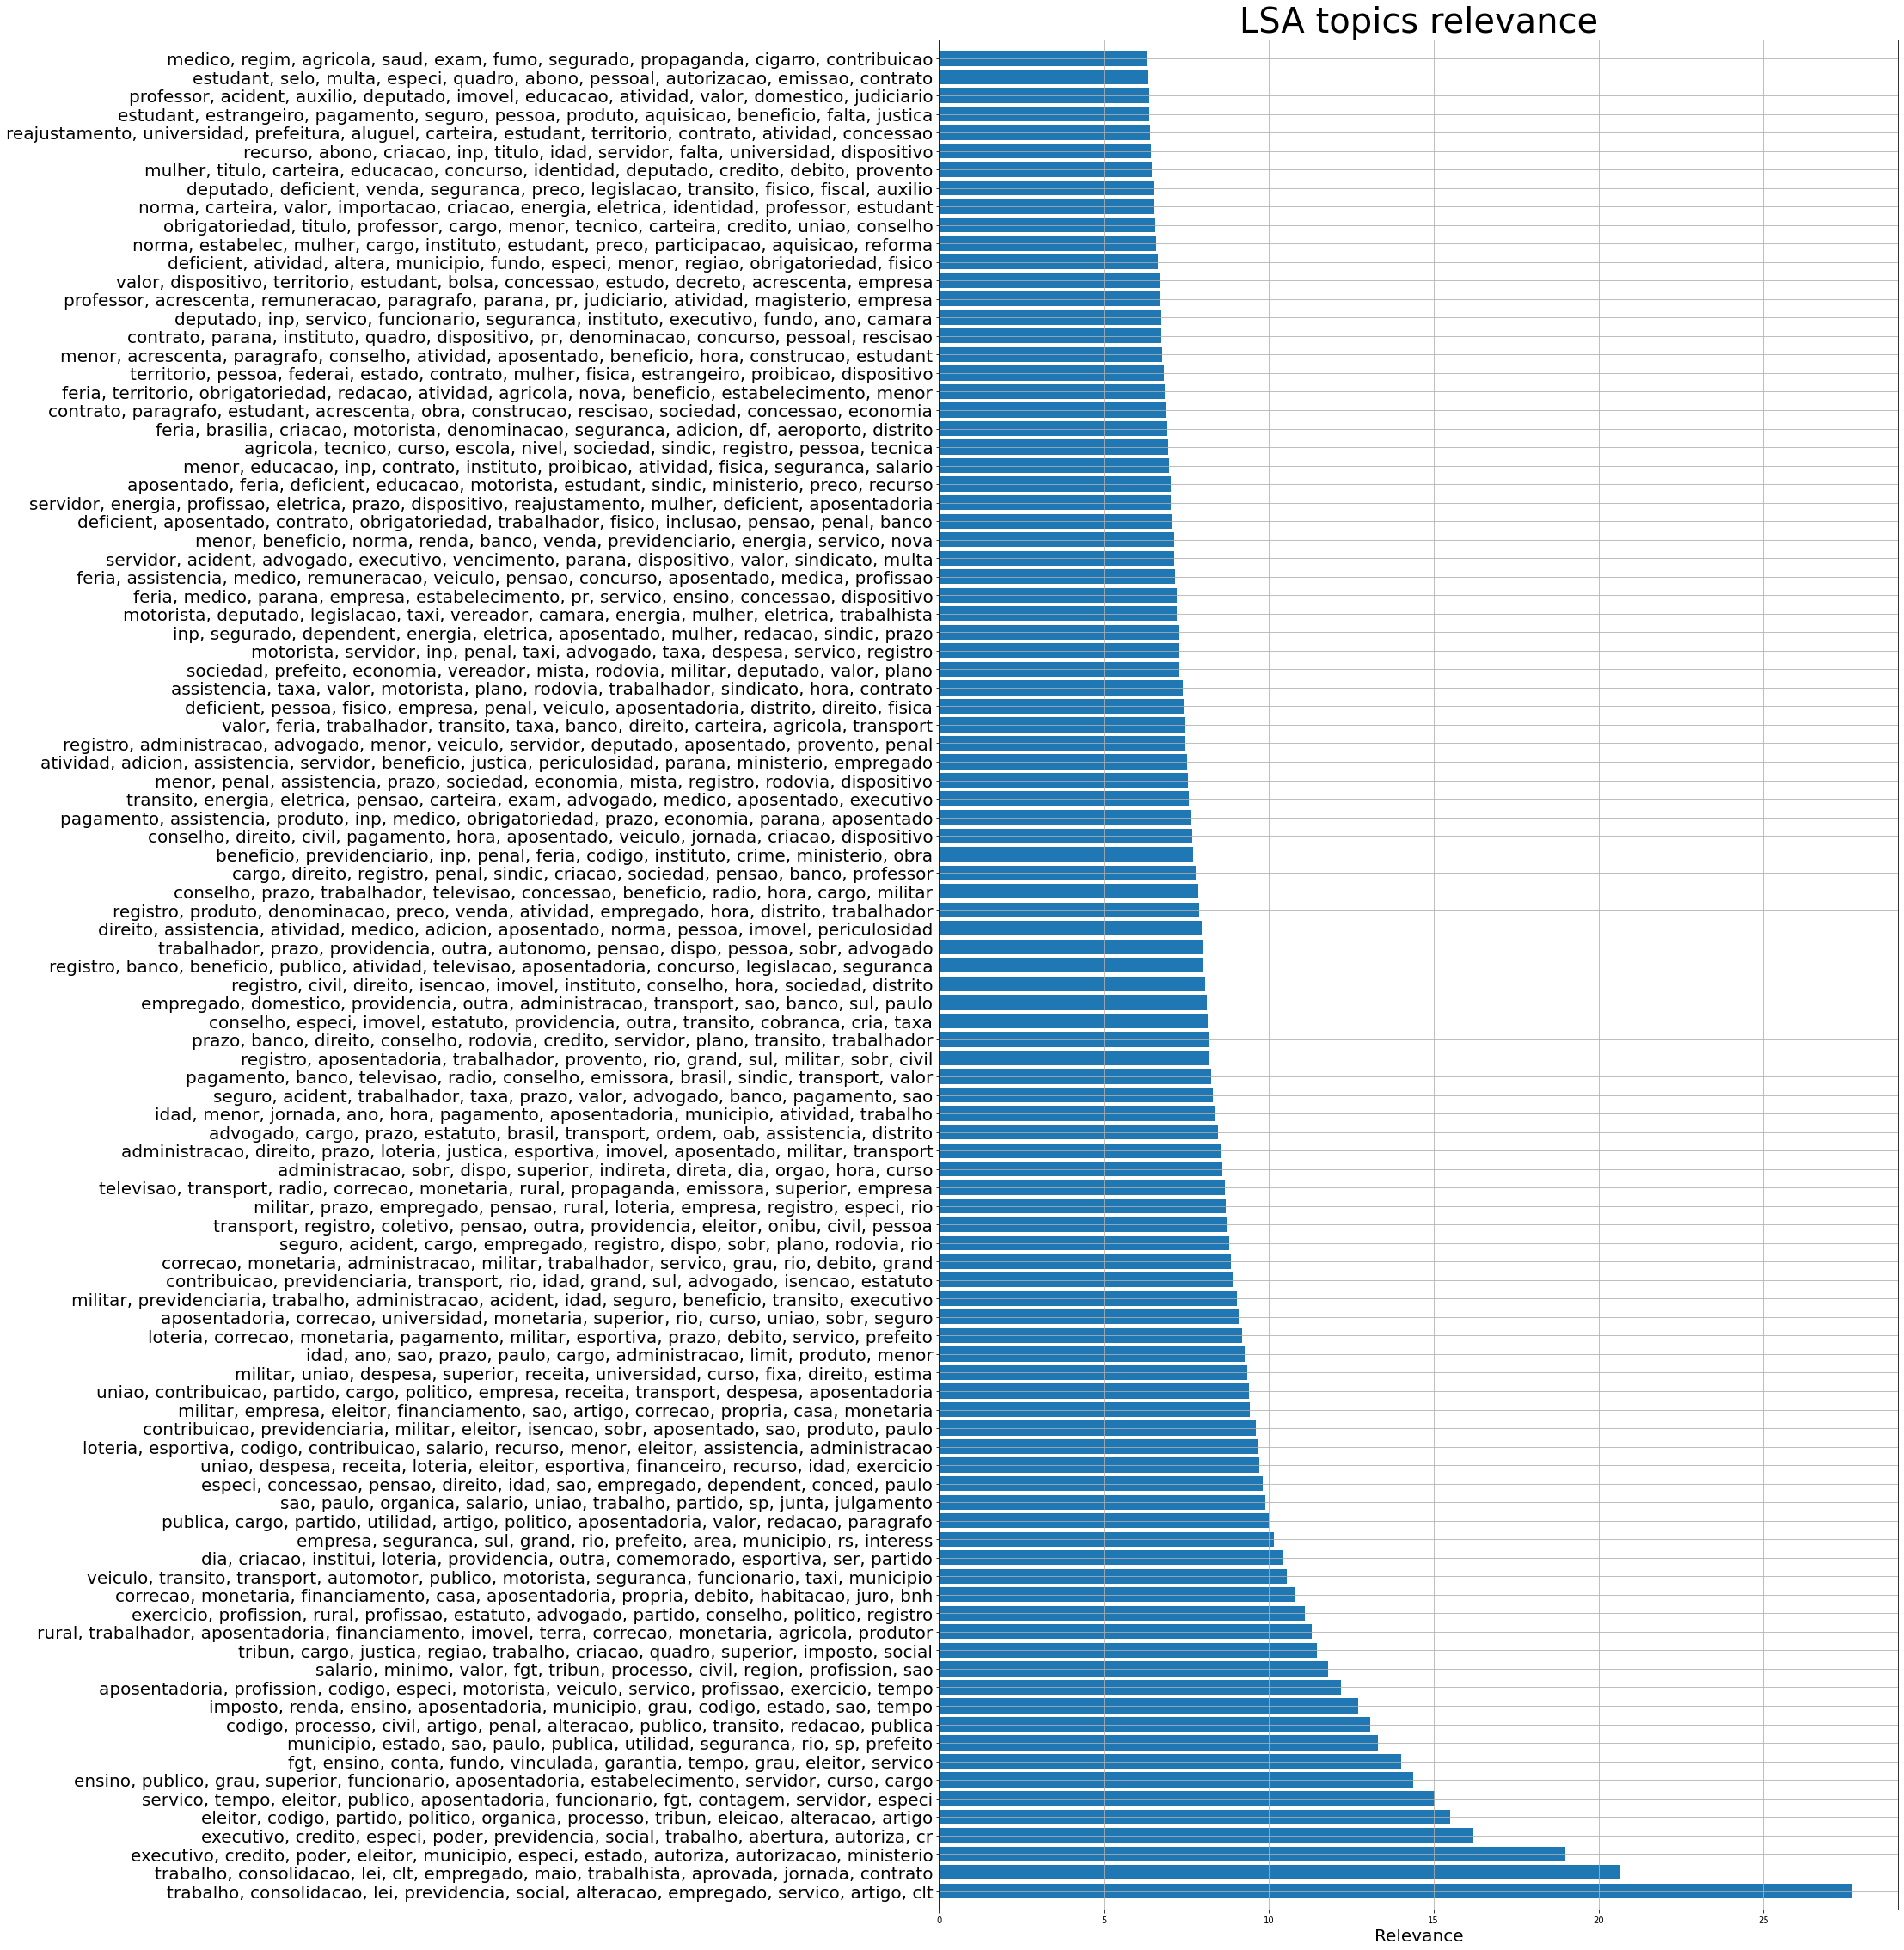

In [64]:
y_pos = np.arange(len(topics))

fig, ax = plt.subplots()
fig.set_figheight(40)
fig.set_figwidth(20)

ax.grid()
ax.barh(y_pos, Sigma, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(topics, fontsize=20)
ax.set_ylim([-1, 100])
ax.set_xlabel('Relevance', fontsize=20)
ax.set_title('LSA topics relevance', fontsize=40)

plt.show()

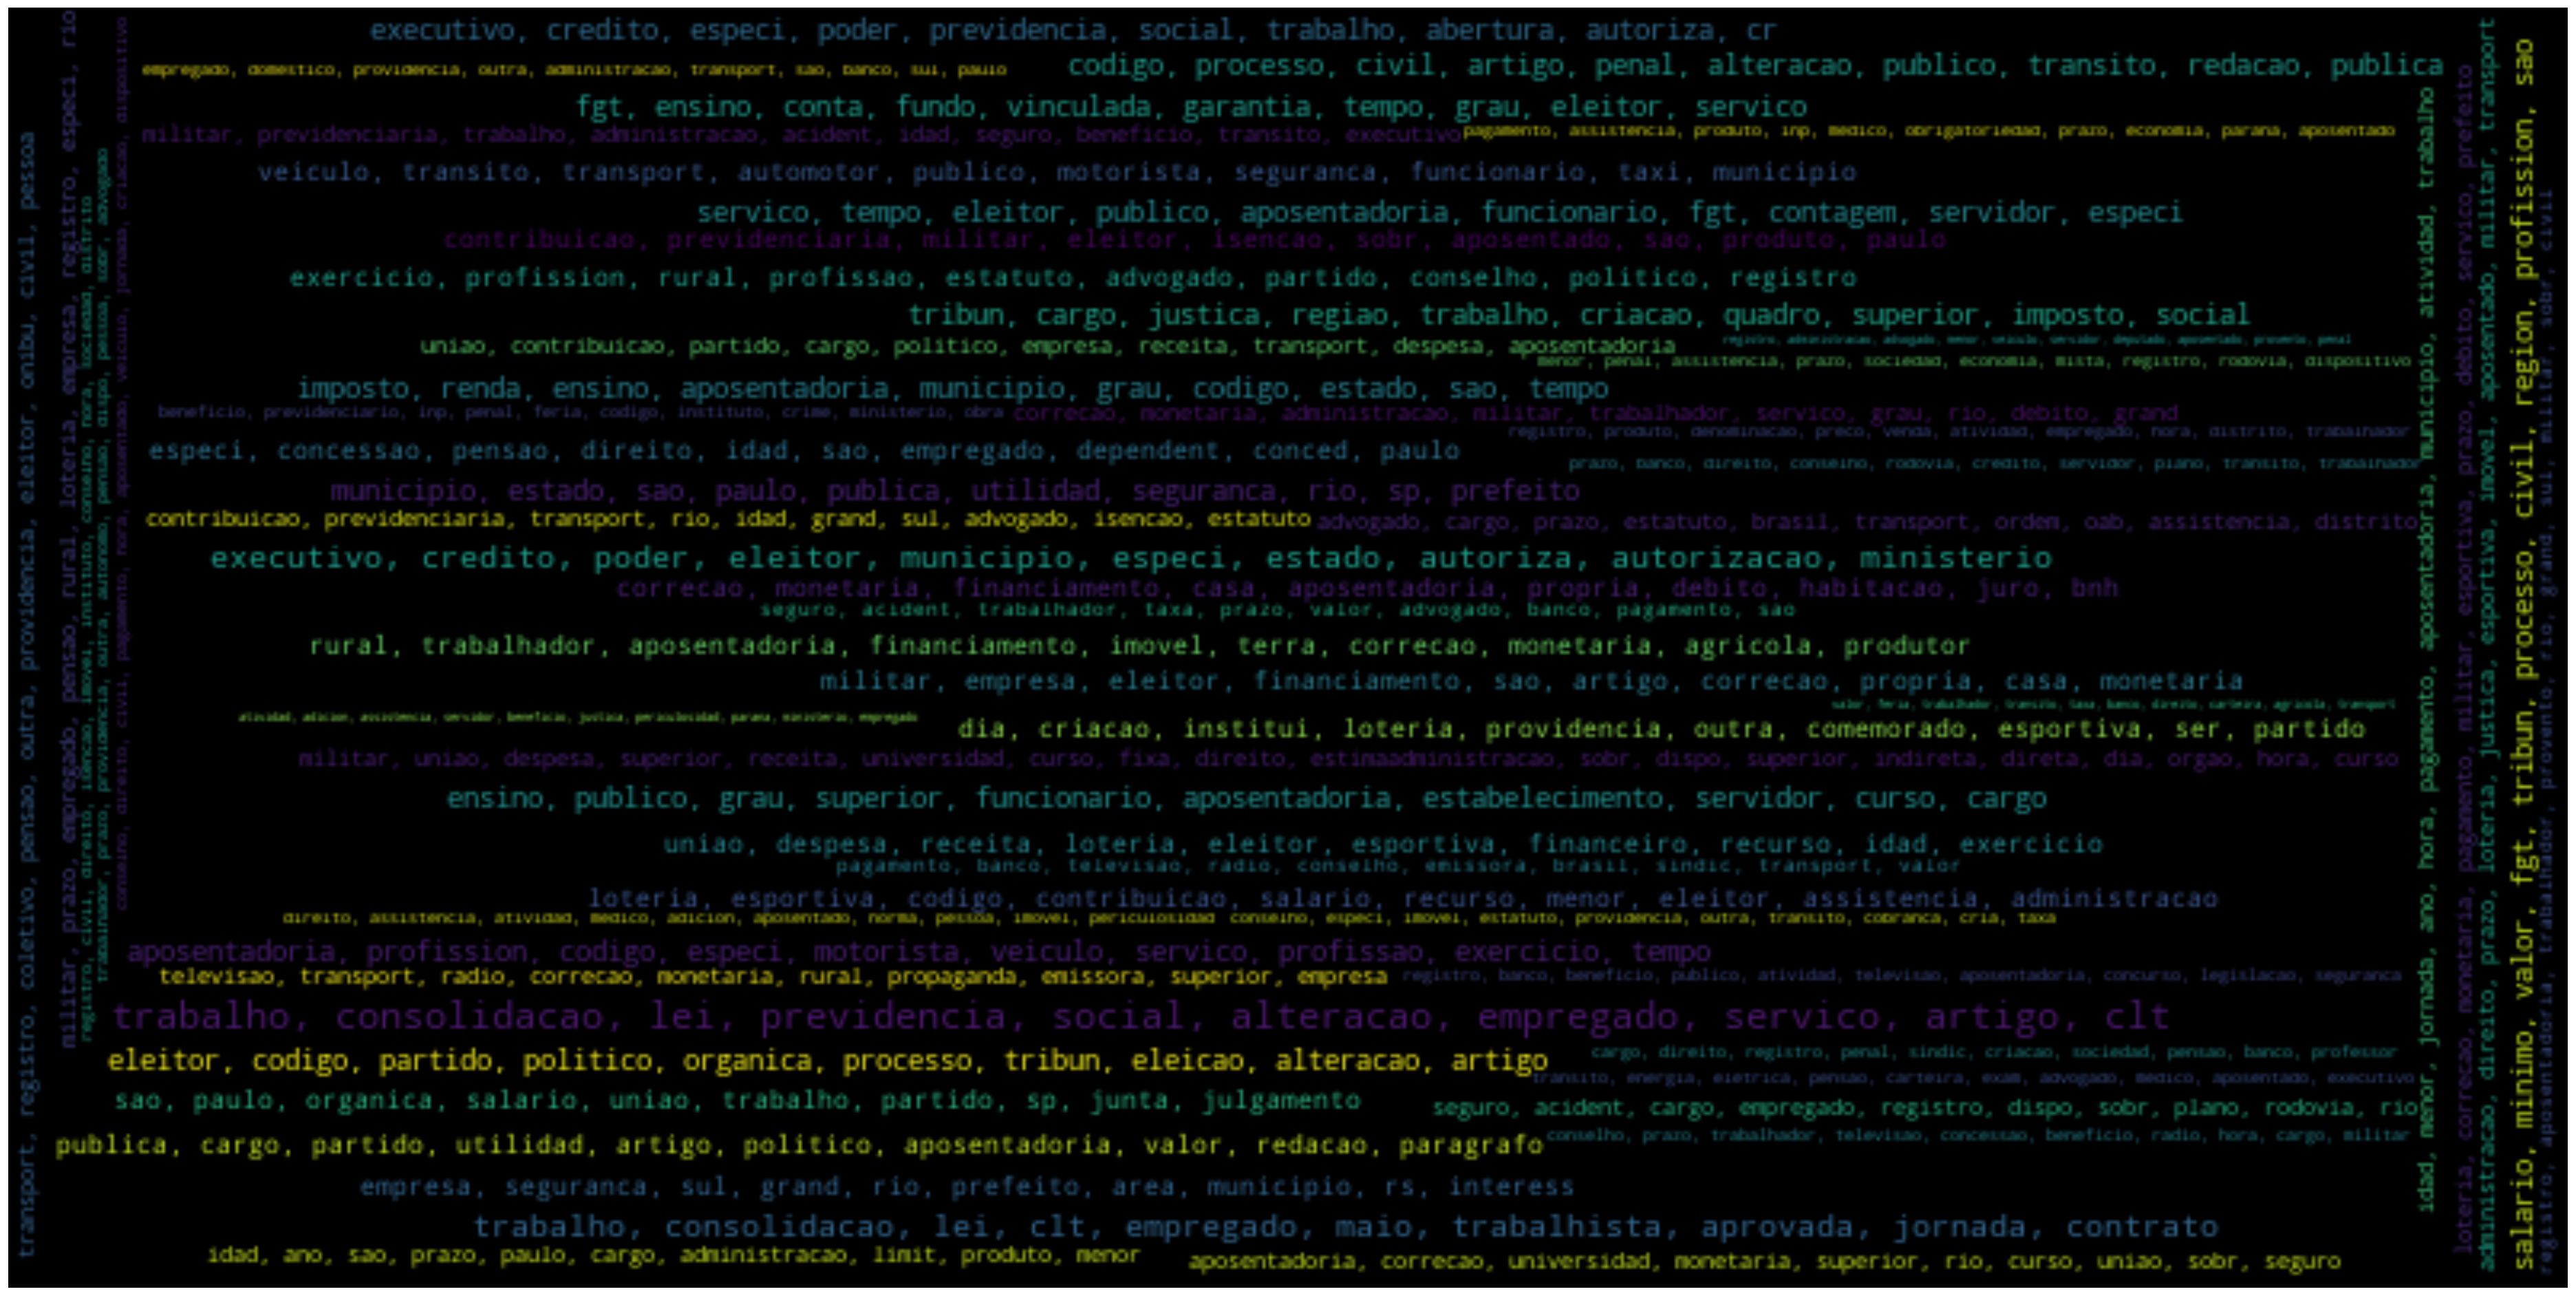

In [65]:
# topic relevance
wordcloud = WordCloud(width=800, height=400, max_words=1000).generate_from_frequencies({v:Sigma[i] for i, v in enumerate(topics)})

plt.figure(figsize=(40, 40), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

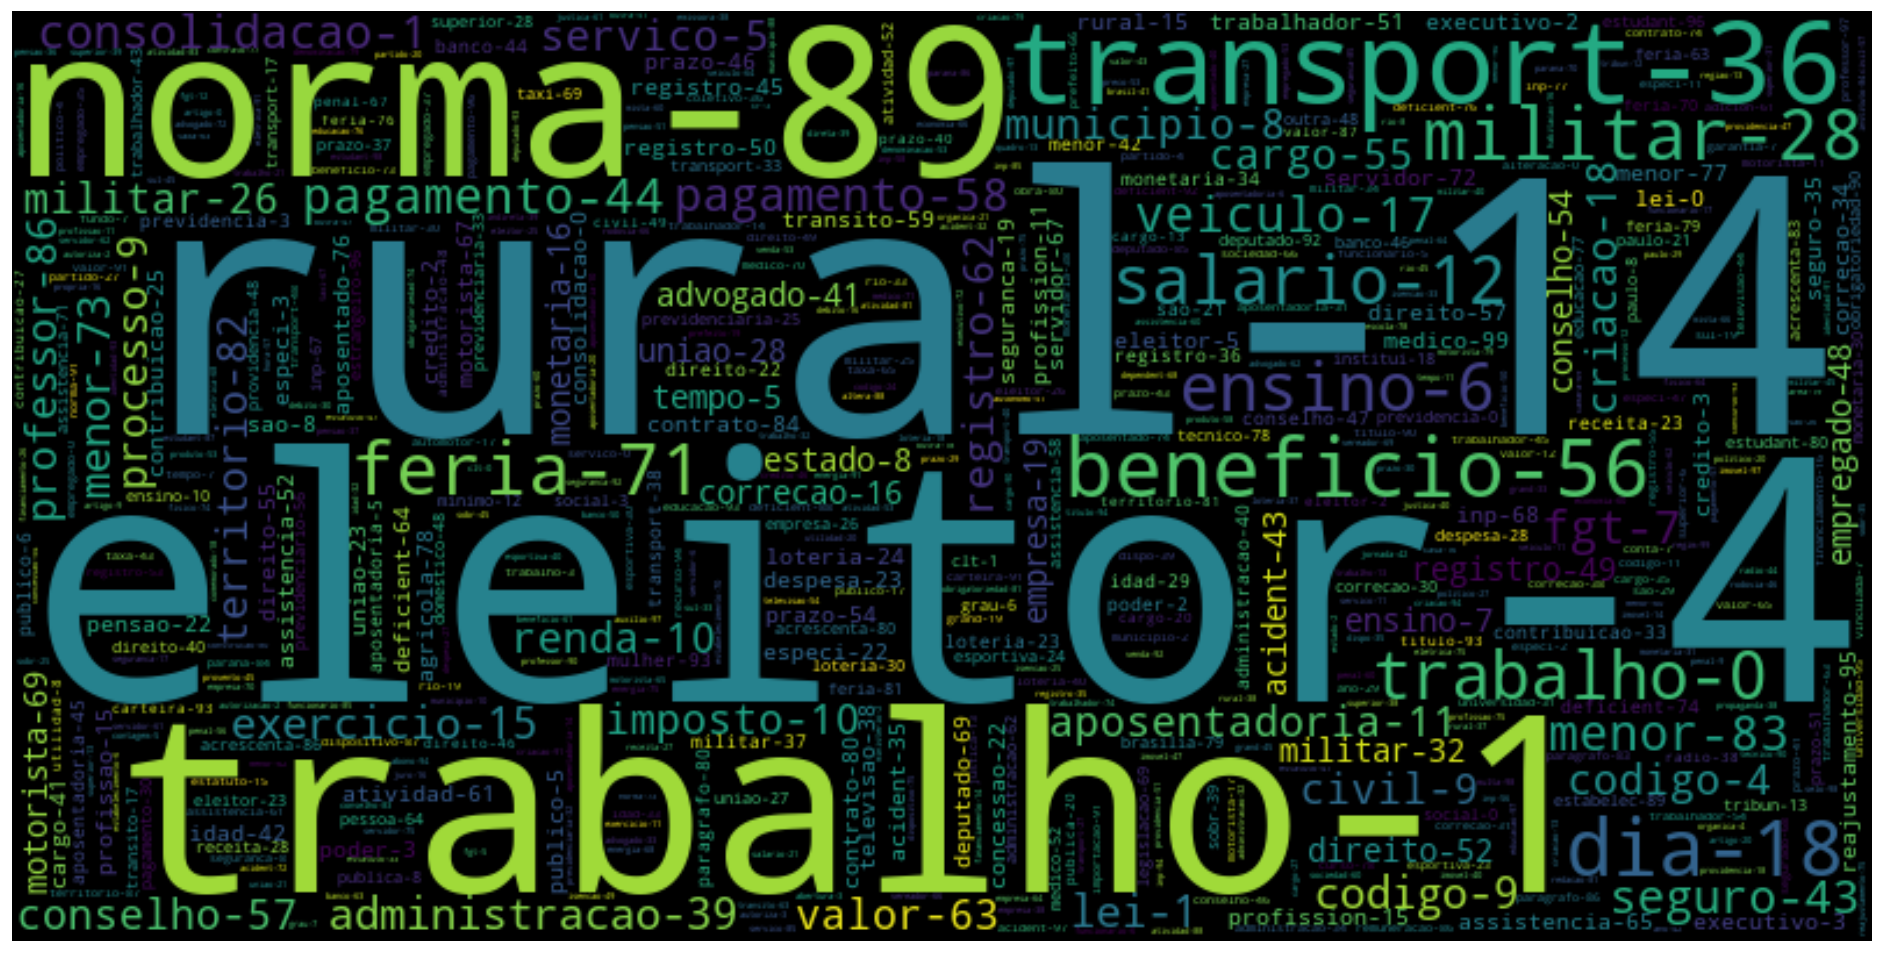

In [66]:
# word relevance for each topic
wordcloud = WordCloud(width=800, height=400, max_words=1000).generate_from_frequencies({f'{k}-{i}':v for i, items in enumerate(topics_relevance) for k, v in items})

plt.figure(figsize=(20, 30), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

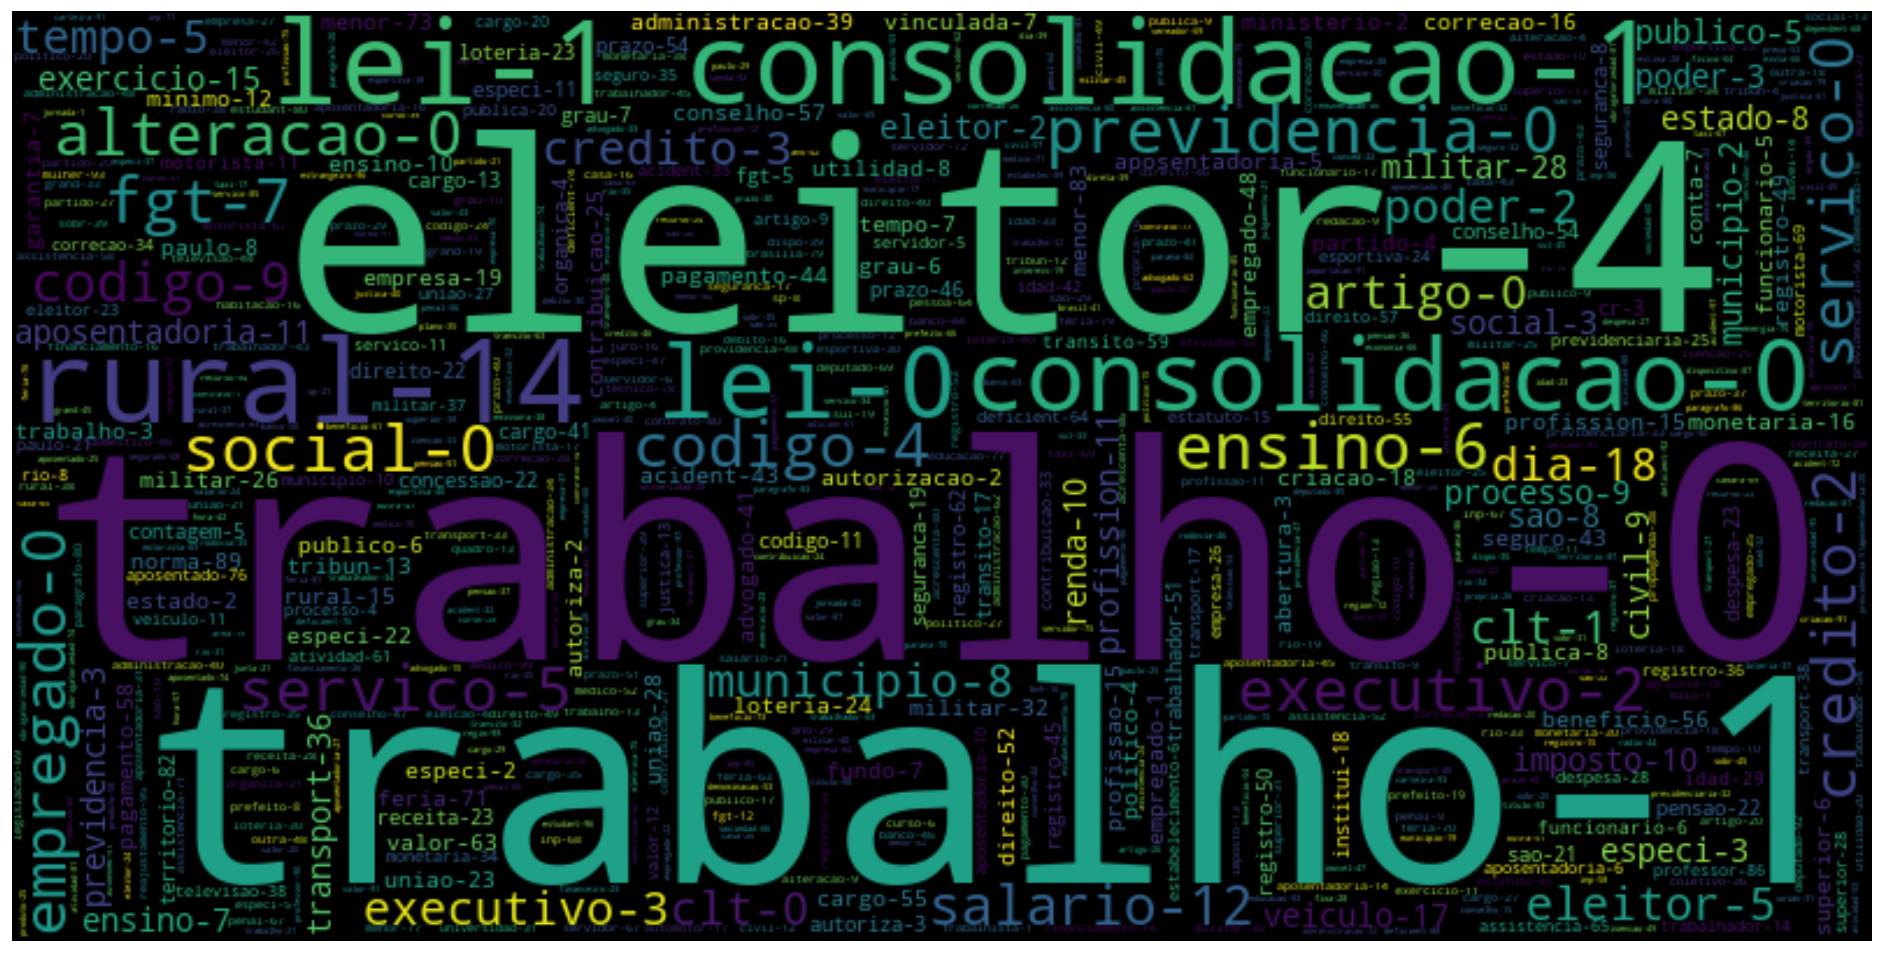

In [67]:
# word relevance for each topic combined with topic relevance
wordcloud = WordCloud(width=800, height=400, max_words=1000).generate_from_frequencies({f'{k}-{i}':v*Sigma[i] for i, items in enumerate(topics_relevance) for k, v in items})

plt.figure(figsize=(20, 30), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()